# dominating set

Set up calculations and store in EspressoDB

In [1]:
import matplotlib.pylab as plt
import seaborn as sns
import os
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"
import numpy as np
import pandas as pd

from qlp.mds import graph_tools as gt
from qlp.mds.qubo import get_mds_qubo
from qlp.mds.solver import classical_search
from qlp.mds.mds_qlpdb import graph_summary, experiment_summary, data_summary, insert_result, QUBO_to_Ising

from networkx import Graph
from networkx.algorithms.approximation import min_weighted_dominating_set

from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite

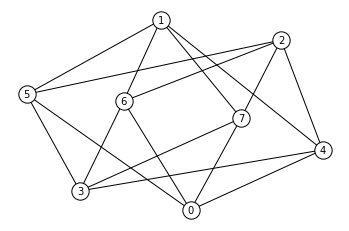

{'tag': 'K(4,4)', 'total_vertices': 8, 'total_edges': 16, 'max_edges': 4, 'adjacency': [[2, 7], [3, 5], [2, 6], [1, 4], [0, 7], [0, 6], [1, 5], [0, 5], [1, 6], [3, 6], [0, 4], [3, 7], [2, 5], [3, 4], [2, 4], [1, 7]], 'adjacency_hash': 'efb57878e4a0a45a89e4ab12bb12ab70'}
Chain strength: 16.0


/Users/ithems/Scripts/quantum_linear_programming/qlp/mds/mds_qlpdb.py:94: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  norm_params = pd.io.json.json_normalize(params, sep="_").to_dict()


0
1
2
3
4
5
6
7
8
9
     0  1  2  3  4  5  6  7  8  9  ...  25  26  27  28  29  30  31  \
319  0  1  0  0  1  0  0  0  0  0  ...   0   0   0   0   0   0   0   
252  1  0  0  0  1  1  0  0  0  1  ...   0   0   0   0   0   0   0   
756  1  0  0  0  0  0  1  0  1  0  ...   0   1   0   0   0   0   0   
107  1  0  0  0  1  1  0  0  0  1  ...   0   0   0   0   0   0   0   
577  1  0  0  0  0  1  0  0  1  0  ...   0   0   0   0   1   0   0   

     chain_break_fraction  energy  num_occurrences  
319               0.00000   -14.0                1  
252               0.09375   -13.0                1  
756               0.06250   -12.0                1  
107               0.06250   -11.0                1  
577               0.06250   -10.0                1  

[5 rows x 35 columns]


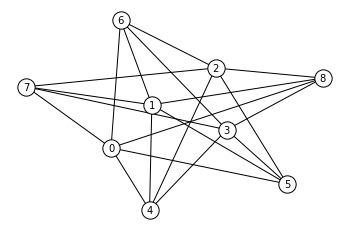

{'tag': 'K(4,5)', 'total_vertices': 9, 'total_edges': 20, 'max_edges': 5, 'adjacency': [[2, 8], [0, 7], [1, 6], [3, 7], [2, 5], [1, 5], [3, 6], [0, 4], [2, 6], [1, 4], [0, 5], [0, 8], [3, 5], [2, 7], [3, 8], [0, 6], [1, 8], [1, 7], [3, 4], [2, 4]], 'adjacency_hash': '991bc580d7f5e6e9259a7a0851ff86db'}
Chain strength: 16.0


/Users/ithems/Scripts/quantum_linear_programming/qlp/mds/mds_qlpdb.py:94: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  norm_params = pd.io.json.json_normalize(params, sep="_").to_dict()


0
1
2
3
4
5
6
7
8
9
     0  1  2  3  4  5  6  7  8  9  ...  29  30  31  32  33  34  35  \
782  1  1  0  0  0  0  0  0  1  1  ...   0   1   0   0   0   1   0   
42   0  1  0  0  1  0  0  1  0  1  ...   0   1   0   0   0   0   0   
228  1  1  1  1  1  1  1  0  0  1  ...   1   1   1   0   1   1   0   
123  1  1  1  0  0  1  0  0  0  1  ...   0   0   1   0   1   1   0   
59   1  0  1  0  0  0  1  1  0  1  ...   0   0   1   0   1   0   0   

     chain_break_fraction  energy  num_occurrences  
782                   0.0   -13.0                1  
42                    0.0   -11.0                1  
228                   0.0   -11.0                1  
123                   0.0   -10.0                1  
59                    0.0   -10.0                1  

[5 rows x 39 columns]


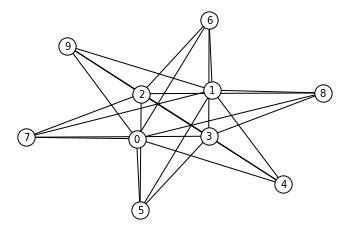

{'tag': 'K(4,6)', 'total_vertices': 10, 'total_edges': 24, 'max_edges': 6, 'adjacency': [[2, 8], [0, 7], [1, 6], [3, 7], [2, 5], [2, 9], [1, 5], [3, 6], [0, 4], [2, 6], [1, 4], [3, 9], [0, 5], [1, 9], [0, 8], [3, 5], [2, 7], [3, 8], [0, 6], [1, 8], [1, 7], [0, 9], [3, 4], [2, 4]], 'adjacency_hash': '3951d111758d8213c54ed47947190654'}
Chain strength: 16.0


/Users/ithems/Scripts/quantum_linear_programming/qlp/mds/mds_qlpdb.py:94: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  norm_params = pd.io.json.json_normalize(params, sep="_").to_dict()


0
1
2
3
4
5
6
7
8
9
     0  1  2  3  4  5  6  7  8  9  ...  33  34  35  36  37  38  39  \
567  0  0  0  1  0  0  0  0  0  1  ...   0   0   0   0   0   0   0   
670  1  0  0  1  0  0  0  0  0  1  ...   0   0   0   0   0   1   0   
31   1  0  0  1  1  1  0  0  0  0  ...   0   1   0   0   1   0   0   
171  1  0  1  0  1  0  0  1  1  0  ...   0   0   1   0   1   0   0   
138  1  0  0  1  0  0  0  0  0  1  ...   0   0   1   0   0   1   0   

     chain_break_fraction  energy  num_occurrences  
567                 0.025   -16.0                1  
670                 0.075   -13.0                1  
31                  0.075   -12.0                1  
171                 0.000   -11.0                1  
138                 0.100   -11.0                1  

[5 rows x 43 columns]


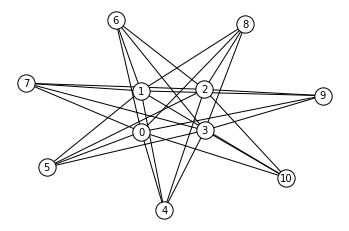

{'tag': 'K(4,7)', 'total_vertices': 11, 'total_edges': 28, 'max_edges': 7, 'adjacency': [[2, 8], [0, 7], [1, 6], [0, 10], [3, 7], [2, 5], [2, 9], [3, 10], [1, 5], [3, 6], [0, 4], [1, 10], [2, 6], [1, 4], [2, 10], [3, 9], [0, 5], [1, 9], [0, 8], [3, 5], [2, 7], [3, 8], [0, 6], [1, 8], [1, 7], [0, 9], [3, 4], [2, 4]], 'adjacency_hash': 'abc1f652946da1de0f31d69071678589'}
Chain strength: 16.0


/Users/ithems/Scripts/quantum_linear_programming/qlp/mds/mds_qlpdb.py:94: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  norm_params = pd.io.json.json_normalize(params, sep="_").to_dict()


0
1
2
3
4
5
6
7
8
9
     0  1  2  3  4  5  6  7  8  9  ...  37  38  39  40  41  42  43  \
82   0  1  0  0  1  1  1  1  1  1  ...   0   0   0   0   1   0   0   
340  0  1  0  0  0  1  1  1  1  1  ...   0   0   0   0   1   0   0   
775  1  0  0  0  1  1  1  1  1  1  ...   0   0   0   0   0   0   0   
20   1  0  0  0  0  1  1  1  1  1  ...   0   0   0   0   1   0   0   
977  1  0  0  0  0  1  1  1  1  1  ...   0   1   0   0   1   0   0   

     chain_break_fraction  energy  num_occurrences  
82               0.204545    14.0                1  
340              0.204545    15.0                1  
775              0.159091    16.0                1  
20               0.204545    19.0                1  
977              0.181818    19.0                1  

[5 rows x 47 columns]


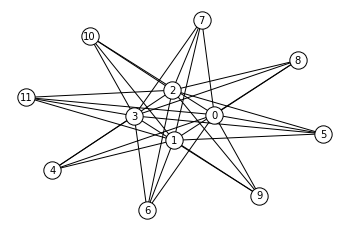

{'tag': 'K(4,8)', 'total_vertices': 12, 'total_edges': 32, 'max_edges': 8, 'adjacency': [[2, 8], [3, 11], [0, 7], [1, 6], [0, 10], [3, 7], [2, 5], [1, 11], [2, 9], [3, 10], [1, 5], [0, 11], [3, 6], [0, 4], [1, 10], [2, 6], [1, 4], [2, 10], [3, 9], [0, 5], [1, 9], [0, 8], [3, 5], [2, 7], [2, 11], [3, 8], [0, 6], [1, 8], [1, 7], [0, 9], [3, 4], [2, 4]], 'adjacency_hash': 'c5a01e77d00ca62b9faf966b6416a807'}
Chain strength: 64.0


/Users/ithems/Scripts/quantum_linear_programming/qlp/mds/mds_qlpdb.py:94: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  norm_params = pd.io.json.json_normalize(params, sep="_").to_dict()


0
1
2
3
4
5
6
7
8
9
     0  1  2  3  4  5  6  7  8  9  ...  45  46  47  48  49  50  51  \
561  1  1  1  0  0  1  0  1  0  0  ...   0   0   1   0   0   1   0   
719  1  1  0  1  0  1  0  0  1  0  ...   0   0   1   0   0   0   1   
446  0  1  1  0  0  1  0  0  1  1  ...   0   1   1   0   0   1   0   
397  1  1  0  0  0  1  0  1  0  0  ...   0   1   1   0   1   1   0   
990  1  0  0  0  1  1  1  0  0  1  ...   0   0   1   0   0   1   0   

     chain_break_fraction  energy  num_occurrences  
561                   0.0    -9.0                1  
719                   0.0    -8.0                1  
446                   0.0    -7.0                1  
397                   0.0    -7.0                1  
990                   0.0    -7.0                1  

[5 rows x 55 columns]


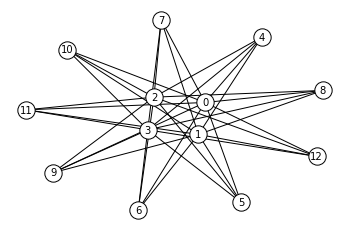

{'tag': 'K(4,9)', 'total_vertices': 13, 'total_edges': 36, 'max_edges': 9, 'adjacency': [[2, 8], [3, 11], [0, 7], [1, 6], [0, 10], [2, 12], [3, 7], [2, 5], [1, 11], [2, 9], [3, 10], [1, 5], [0, 11], [3, 6], [0, 4], [1, 10], [2, 6], [1, 4], [0, 12], [2, 10], [3, 9], [0, 5], [1, 9], [0, 8], [3, 5], [2, 7], [3, 12], [1, 12], [2, 11], [3, 8], [0, 6], [1, 8], [1, 7], [0, 9], [3, 4], [2, 4]], 'adjacency_hash': '2a9263aac8e1bbfd5f7f5284aad8d18f'}
Chain strength: 64.0


/Users/ithems/Scripts/quantum_linear_programming/qlp/mds/mds_qlpdb.py:94: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  norm_params = pd.io.json.json_normalize(params, sep="_").to_dict()


0
1
2
3
4
5
6
7
8
9
     0  1  2  3  4  5  6  7  8  9  ...  49  50  51  52  53  54  55  \
235  0  0  1  1  0  0  1  1  0  0  ...   0   1   0   0   1   0   0   
631  1  0  0  1  0  0  1  1  1  1  ...   0   0   0   0   1   0   0   
939  1  0  0  1  0  0  1  1  1  0  ...   0   0   1   0   0   1   0   
786  0  1  1  0  0  1  1  0  1  0  ...   0   1   1   0   1   0   0   
144  1  0  0  0  1  0  0  0  1  0  ...   0   1   0   0   1   0   0   

     chain_break_fraction  energy  num_occurrences  
235                   0.0    -8.0                1  
631                   0.0    -6.0                1  
939                   0.0    -5.0                1  
786                   0.0    -5.0                1  
144                   0.0    -5.0                1  

[5 rows x 59 columns]


In [7]:
# Define Adjacency matrix
# Hamming(d,q)
# Biparti
# NN(v): 1D nearest neighbor with v vertices. max is 16 before minor embedding starts breaking
#graph, tag = gt.generate_hamming_graph(1, 2)
#graph, tag = gt.generate_bipartite_graph(3, 3)
for nvertices in range(4,10):
    graph, tag = gt.generate_bipartite_graph(4, nvertices)
    penalty = 2

    directed = False
    qubo = get_mds_qubo(graph, directed=directed, penalty = penalty, triangularize=True, dtype="d")
    q_min = np.array(list(qubo.values())).min()

    gt.get_plot(graph, directed=directed)
    plt.show()
    graph_params = graph_summary(tag, graph)
    print(graph_params)

    # Experiment
    J, h, C = QUBO_to_Ising(qubo.todense().tolist())
    maxJ = max(abs(J).flatten())
    maxh = max(abs(h))
    #print("Initial")
    #print(f"max(J) = {maxJ}")
    #print(f"max(h) = {maxh}")
    #print("DWave J_range = [-1.0, 1.0] \nDWave h_range = [-2.0, 2.0]")
    #print("Must scale QUBO to these ranges\n")
    fact = 1 #max([maxJ, maxh/2]) * 1.2
    qubo = qubo / fact

    J, h, C = QUBO_to_Ising(qubo.todense().tolist())
    maxJ = max(abs(J).flatten())
    maxh = max(abs(h))
    #print("Rescaled")
    #print(f"max(J) = {maxJ}")
    #print(f"max(h) = {maxh}")
    #print("DWave J_range = [-1.0, 1.0] \nDWave h_range = [-2.0, 2.0]")
    #print("Must scale QUBO to these ranges\n")

    # Set chain strength
    chain_strength = maxJ*2
    print(f"Chain strength: {chain_strength}")

    # DWave settings
    dwave_config = {
        "annealing_time": 500,  # integer microseconds [1, 2000]
        "answer_mode": "raw", # histogram or raw
        "auto_scale": True,
        "num_reads": 1000,  # raw will dump out all results
        "num_spin_reversal_transforms": 0,
        "readout_thermalization": 0, # default 0
        "programming_thermalization": 1000, # default 1000
        "chain_strength": chain_strength
    }
    solver = "DW_2000Q_5"

    experiment_params = experiment_summary(machine=solver, settings=dwave_config, penalty=penalty, factor=fact, chain_strength=chain_strength, qubo=qubo)


    # Solve on DWave and push to database
    sampler = DWaveSampler(solver=solver)
    embed = EmbeddingComposite(sampler)
    qubo_dict = {key: val for key, val in zip(qubo.keys(), qubo.values())}
    for idx in range(10):
        print(idx)
        result = embed.sample_qubo(qubo_dict, **dwave_config)
        raw = result.to_pandas_dataframe()
        data_params = data_summary(raw, graph_params, experiment_params)
        result = insert_result(graph_params, experiment_params, data_params)
    print(raw.sort_values("energy", ascending=True).head())

In [3]:
#classical_search(qubo)

In [4]:
from qlpdb.data.models import Data as data_Data

In [5]:
data_Data.objects.filter(experiment__graph__tag="NN(2)").to_dataframe()

,id,last_modified,user,tag,experiment,measurement,spin_config,chain_break_fraction,energy,constraint_satisfaction
0,10000,2020-03-01 07:13:38.541250+00:00,admin,None,"Experiment[Base](machine=DW_2000Q_5, settings=...",9999,"[1, 0, 0, 0]",0.0,1.0,True
1,9999,2020-03-01 07:13:38.537817+00:00,admin,None,"Experiment[Base](machine=DW_2000Q_5, settings=...",9998,"[0, 1, 0, 0]",0.0,1.0,True
2,9998,2020-03-01 07:13:38.534300+00:00,admin,None,"Experiment[Base](machine=DW_2000Q_5, settings=...",9997,"[1, 0, 0, 0]",0.0,1.0,True
3,9997,2020-03-01 07:13:38.530828+00:00,admin,None,"Experiment[Base](machine=DW_2000Q_5, settings=...",9996,"[0, 1, 0, 0]",0.0,1.0,True
4,9996,2020-03-01 07:13:38.527417+00:00,admin,None,"Experiment[Base](machine=DW_2000Q_5, settings=...",9995,"[0, 1, 0, 0]",0.0,1.0,True
...,...,...,...,...,...,...,...,...,...,...
9995,5,2020-03-01 07:12:43.461485+00:00,admin,None,"Experiment[Base](machine=DW_2000Q_5, settings=...",4,"[1, 0, 0, 0]",0.0,1.0,True
9996,4,2020-03-01 07:12:43.457339+00:00,admin,None,"Experiment[Base](machine=DW_2000Q_5, settings=...",3,"[0, 1, 0, 0]",0.0,1.0,True
9997,3,2020-03-01 07:12:43.453221+00:00,admin,None,"Experiment[Base](machine=DW_2000Q_5, settings=...",2,"[1, 0, 0, 0]",0.0,1.0,True
9998,2,2020-03-01 07:12:43.449132+00:00,admin,None,"Experiment[Base](machine=DW_2000Q_5, settings=...",1,"[1, 0, 0, 0]",0.0,1.0,True


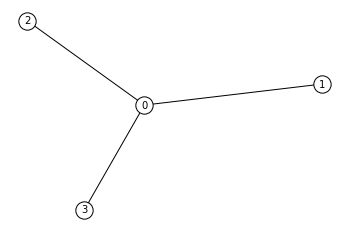

{'tag': 'K(1,3)', 'total_vertices': 4, 'total_edges': 3, 'max_edges': 3, 'adjacency': [[0, 1], [0, 3], [0, 2]], 'adjacency_hash': '19a0318c189e95cb60e3c9bbdb30718d'}


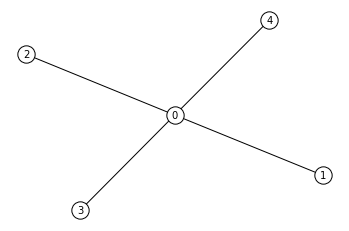

{'tag': 'K(1,4)', 'total_vertices': 5, 'total_edges': 4, 'max_edges': 4, 'adjacency': [[0, 1], [0, 3], [0, 2], [0, 4]], 'adjacency_hash': 'b64f3c3e64eab2d881ca3078c3513b6e'}


In [6]:
for nvertices in range(3,5):
    graph, tag = gt.generate_bipartite_graph(1, nvertices)
    penalty = 2

    directed = False
    qubo = get_mds_qubo(graph, directed=directed, penalty = penalty, triangularize=True, dtype="d")
    q_min = np.array(list(qubo.values())).min()

    gt.get_plot(graph, directed=directed)
    plt.show()
    graph_params = graph_summary(tag, graph)
    print(graph_params)